In [41]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import ipywidgets as widgets
from IPython import display

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
import sys
sys.path.append('/h/ashlie/jupyter_helpers')
import plot_helper as ph

import os

In [45]:
objs = []

In [46]:
# time ms in msec, latency us in nsec.
base_path = '/h/ashlie/new-benchmark-testing/'
op_types = [
    #'read',
    #'randread',
    'write',
    #'randwrite',
]
queue_sizes = [
    1,
    #2,
    #4,
    8,
    #16,
    #32,
    64,
    #128,
    #256,
    512,
    #1024,
    #2048,
    4096,
]
latf = '_lat.log'

devs = {
    #'spdk',
    #'spdk_delay',
    'spdk_batch',
    'spdk_delay_batch',
    #'spdk4096_batch',
    #'spdk_optane',
    #'spdk_optane_delay',
    'spdk_optane_batch',
    'spdk_optane_delay_batch',
    #'sync',
    #'sync_force_sync',
    #'sync_ramdisk',
}

blk_sizes = {
    512,
    #1024,
    #2048,
    #4096,
}

# TODO(t-asmart): Make this easier to handle without having to clobber objs.
for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                if 'spdk4096' in dev and bs != 4096:
                    # Minimum block size for this device is 4K.
                    continue
                objs.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev,
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    latf)
                })

# Total time in sec
total_time = 10
bytes_per_mb = 1024 ** 2

large_fig_dim = (15, 10.6)

In [47]:
len(objs)

20

In [48]:
for obj in objs:
    obj['df'] = pd.read_csv(obj['filePath'], sep=',',
                            names=['io start (ns)', 'latency (ns)',
                                   'block size', 'current queue depth', 'completion batch size'])

In [49]:
latVQd = {}
for op in op_types:
    latVQd[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        latVQd[op] = latVQd[op].append({
            'Device': obj['device'],
            'average latency (us)': obj['df']['latency (ns)'].mean() / 1000,
            'max queue depth': obj['queueSize'],
            'block size': int(obj['blockSize']),
        }, ignore_index=True)

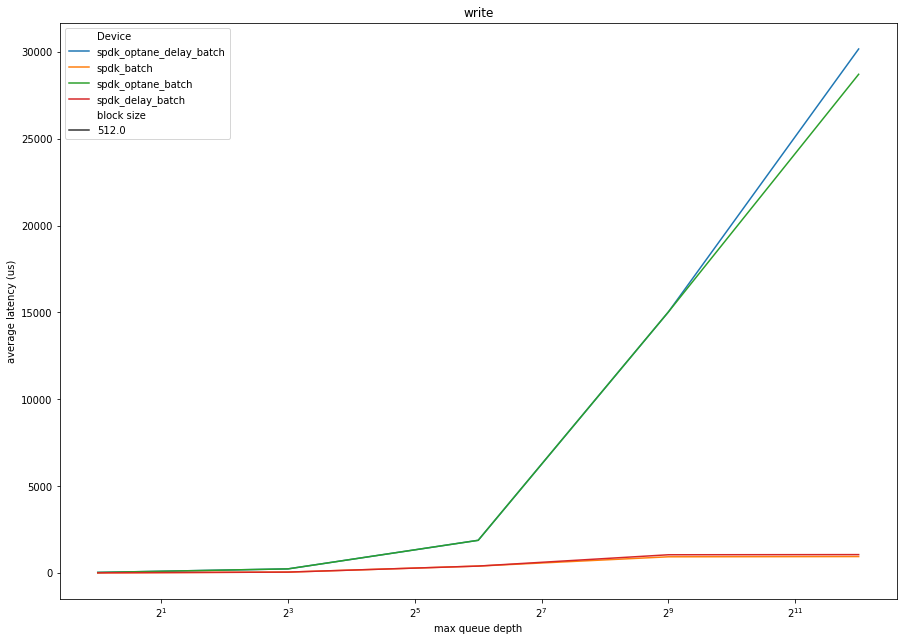

In [50]:
figLatVQd, axesLatVQd = plt.subplots(nrows=len(latVQd), ncols=1,
                                     figsize=(large_fig_dim[0], large_fig_dim[1] * len(latVQd)))
row = 0
for k, p in latVQd.iteritems():
    sns.lineplot(x='max queue depth', y='average latency (us)', data=p,
                 hue='Device', style='block size', ax=axesLatVQd)
    axesLatVQd.set_xscale('log', basex=2)
    axesLatVQd.set_title(k)
    row += 1

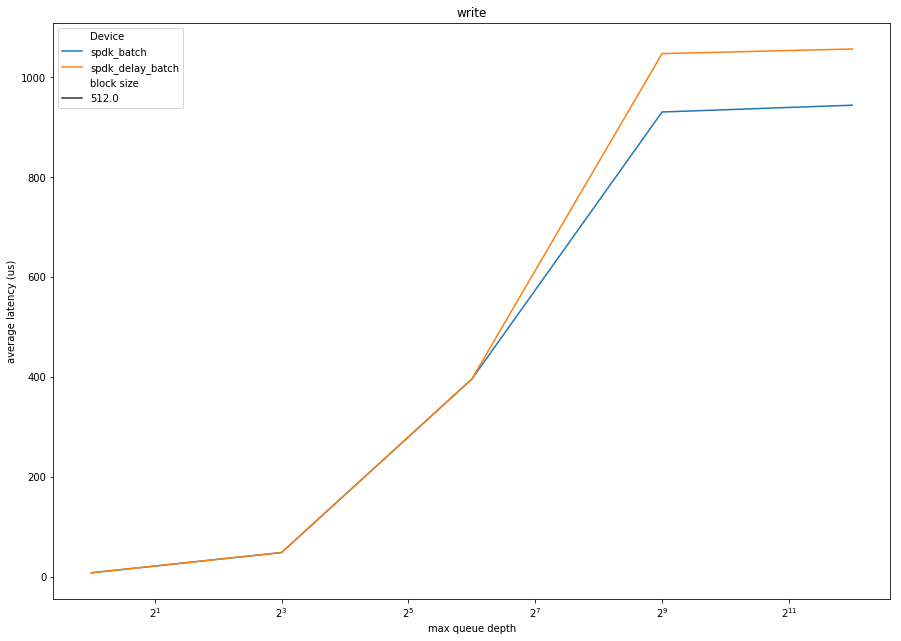

In [51]:
figLatVQd, axesLatVQd = plt.subplots(nrows=len(latVQd), ncols=1,
                                     figsize=(large_fig_dim[0], large_fig_dim[1] * len(latVQd)))
row = 0
for k, p in latVQd.iteritems():
    sns.lineplot(x='max queue depth', y='average latency (us)',
                 data=p[(p['Device'] == 'spdk_batch') | (p['Device'] == 'spdk_delay_batch')],
                 hue='Device', style='block size', ax=axesLatVQd)
    axesLatVQd.set_xscale('log', basex=2)
    axesLatVQd.set_title(k)
    row += 1

In [53]:
latVCqd = {}
for op in op_types:
    latVCqd[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        tmp = obj['df'].sample(n=500, random_state=42)
        tmp['Device'] = obj['device']
        tmp['latency (us)'] = tmp['latency (ns)'] / 1000
        tmp.drop(columns=['latency (ns)', 'io start (ns)', 'completion batch size'], inplace=True)
        latVCqd[op] = latVCqd[op].append(tmp)

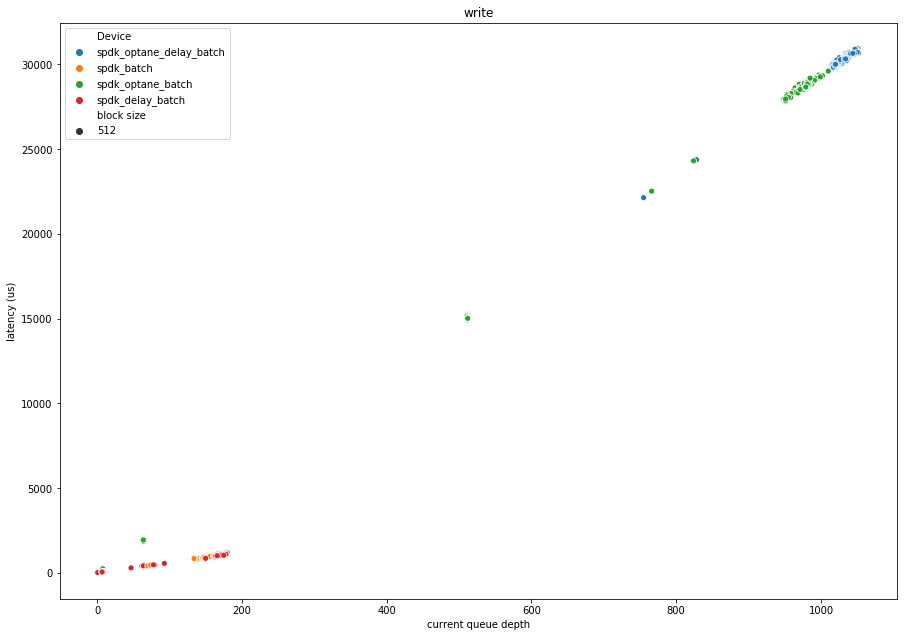

In [54]:
figLatVCqd, axesLatVCqd = plt.subplots(nrows=len(latVCqd), ncols=1,
                                       figsize=(large_fig_dim[0], large_fig_dim[1] * len(latVCqd)))
row = 0
for k, p in latVCqd.iteritems():
    sns.scatterplot(x='current queue depth', y='latency (us)', data=p,
                 hue='Device', style='block size', ax=axesLatVCqd)
    #axesLatVCQd[row].set_xscale('log', basex=2)
    axesLatVCqd.set_title(k)
    row += 1

In [55]:
compVBlk = {}
for op in op_types:
    compVBlk[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        tmp = obj['df'].sample(n=500, random_state=42)
        tmp['Device'] = obj['device']
        tmp.drop(columns=['latency (ns)', 'io start (ns)', 'current queue depth'], inplace=True)
        compVBlk[op] = compVBlk[op].append(tmp)

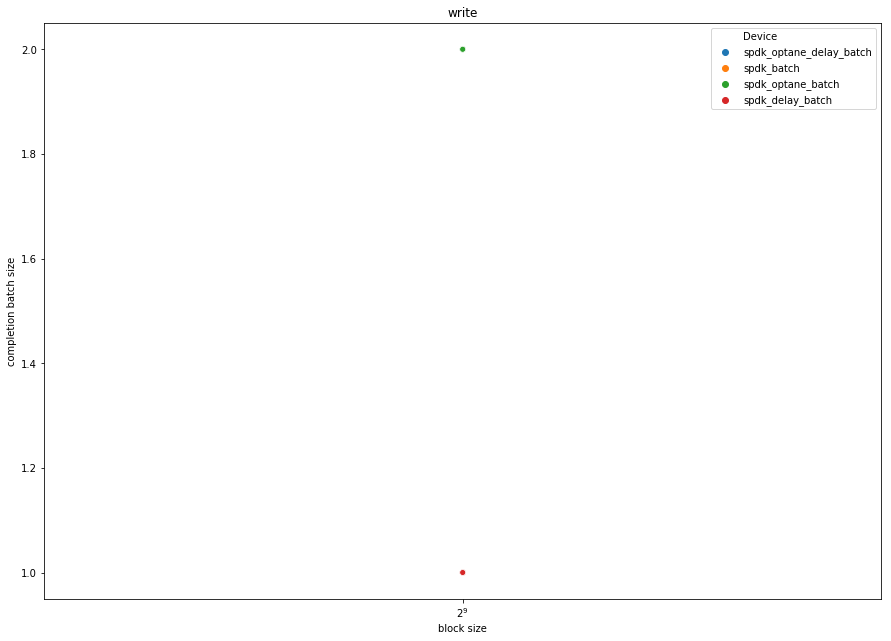

In [56]:
figCompVBlk, axesCompVBlk = plt.subplots(nrows=len(compVBlk), ncols=1,
                                         figsize=(large_fig_dim[0], large_fig_dim[1] * len(compVBlk)))
row = 0
for k, p in compVBlk.iteritems():
    sns.scatterplot(x='block size', y='completion batch size', data=p,
                 hue='Device', ax=axesCompVBlk)
    axesCompVBlk.set_xscale('log', basex=2)
    axesCompVBlk.set_title(k)
    row += 1

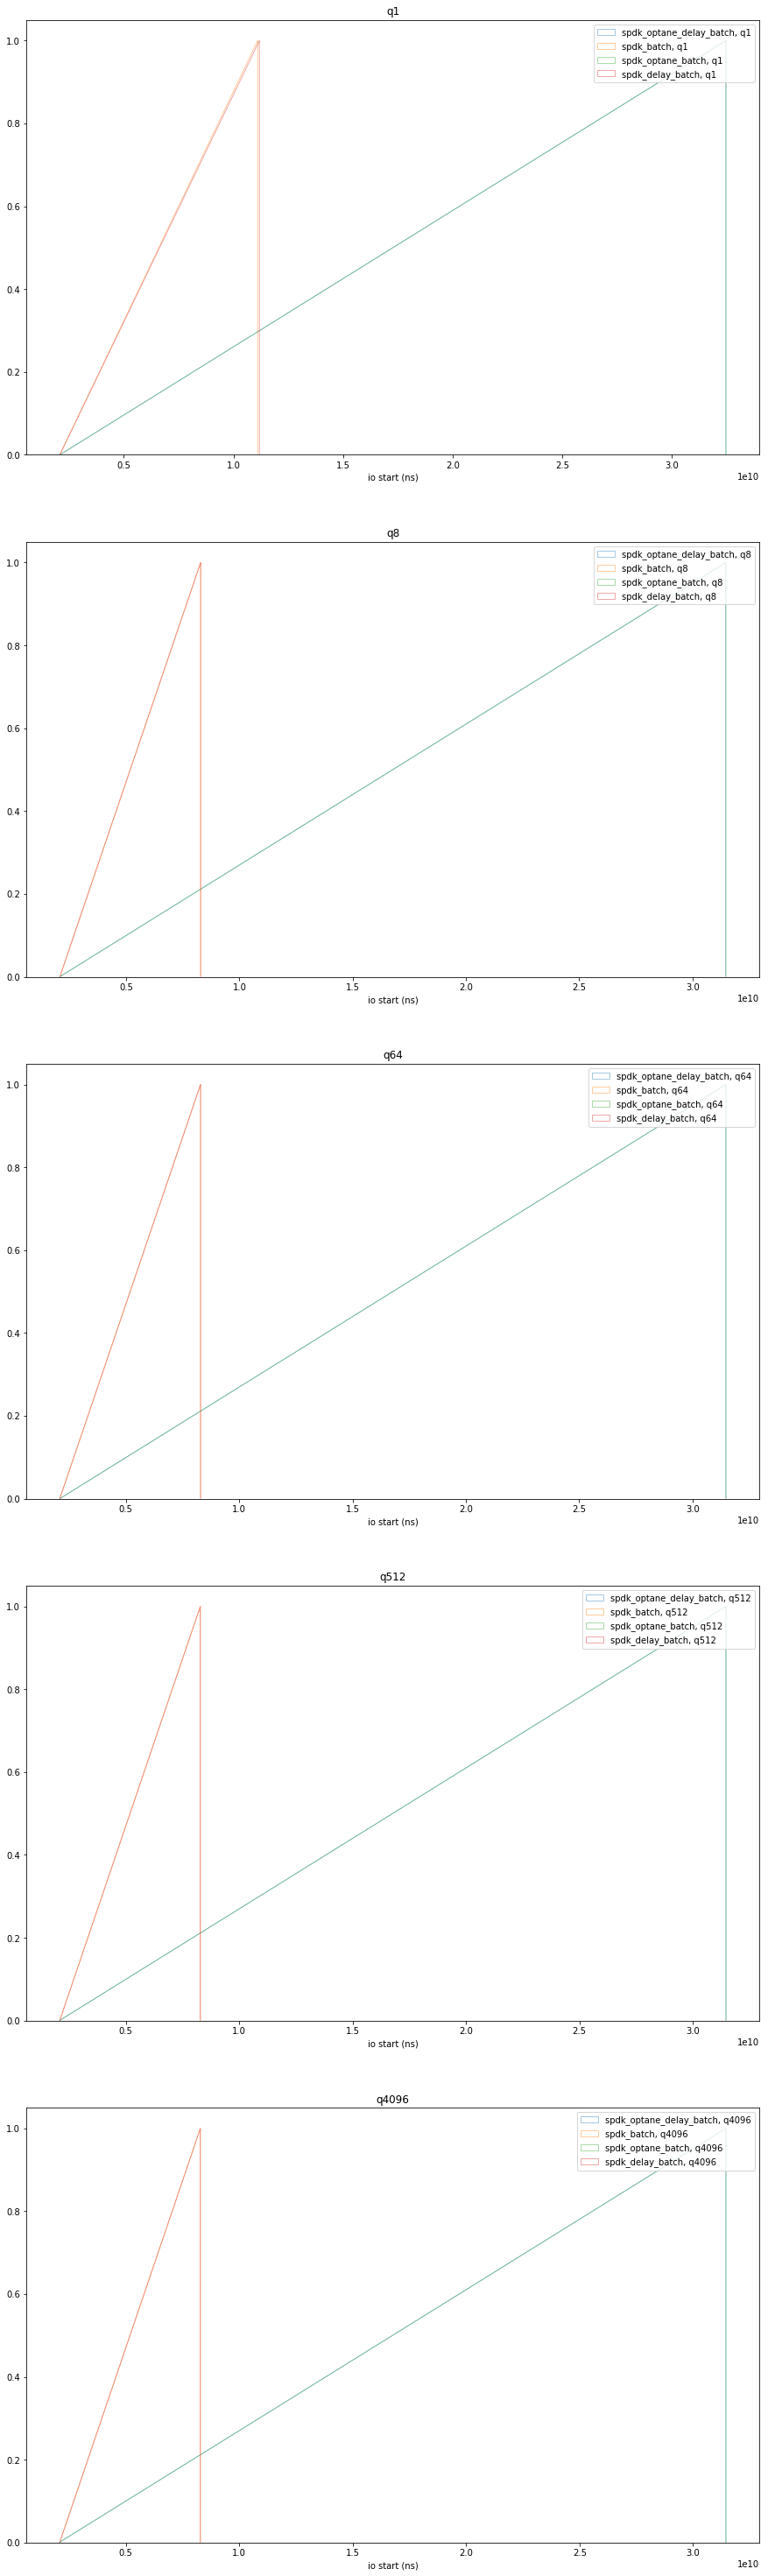

In [57]:
figSubmitTime2, axesSubmitTime2 = plt.subplots(nrows=len(queue_sizes), ncols=1,
                                               figsize=(large_fig_dim[0], large_fig_dim[1] * len(queue_sizes)))
for obj in objs:
    sns.distplot(obj['df']['io start (ns)'], kde=False, hist=True, rug=False, bins=obj['df']['io start (ns)'].size,
                 hist_kws={'histtype': 'step', 'density': True, 'cumulative': True},
                 label=obj['device'] + ', q' + str(obj['queueSize']), ax=axesSubmitTime2[queue_sizes.index(obj['queueSize'])])
for i in range(len(queue_sizes)):
    axesSubmitTime2[i].set_title('q' + str(queue_sizes[i]))
    axesSubmitTime2[i].legend()

In [58]:
for obj in objs:
    obj['CompleteDiff'] = obj['df']['io start (ns)'].diff()

In [59]:
completeDifs = {}
for op in op_types:
    completeDifs[op] = pd.DataFrame()
    for obj in objs:
        if obj['op'] != op:
            continue
        completeDifs[op] = completeDifs[op].append({
            'Device': obj['device'],
            'average complete dif (us)': obj['CompleteDiff'].mean() / 1000,
            'max queue depth': obj['queueSize'],
            'block size': int(obj['blockSize']),
        }, ignore_index=True)

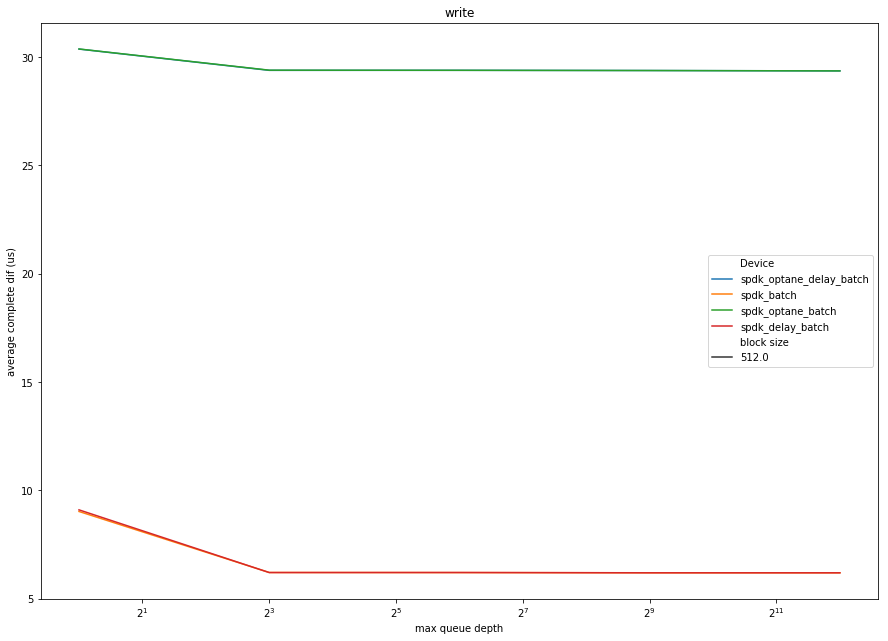

In [60]:
figCompleteDifs, axesCompleteDifs = plt.subplots(nrows=len(completeDifs), ncols=1,
                                     figsize=(large_fig_dim[0], large_fig_dim[1] * len(completeDifs)))
row = 0
for k, p in completeDifs.iteritems():
    sns.lineplot(x='max queue depth', y='average complete dif (us)', data=p,
                 hue='Device', style='block size', ax=axesCompleteDifs)
    axesCompleteDifs.set_xscale('log', basex=2)
    axesCompleteDifs.set_title(k)
    row += 1

In [119]:
subObjs = []

In [120]:
subf = '_submit.log'

for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                if 'spdk4096' in dev and bs != 4096:
                    # Minimum block size for this device is 4K.
                    continue
                subObjs.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev,
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    subf)
                })

In [121]:
for obj in subObjs:
    obj['df'] = pd.read_csv(obj['filePath'], sep=',', names=['start time (ns)', 'latency (ns)'])

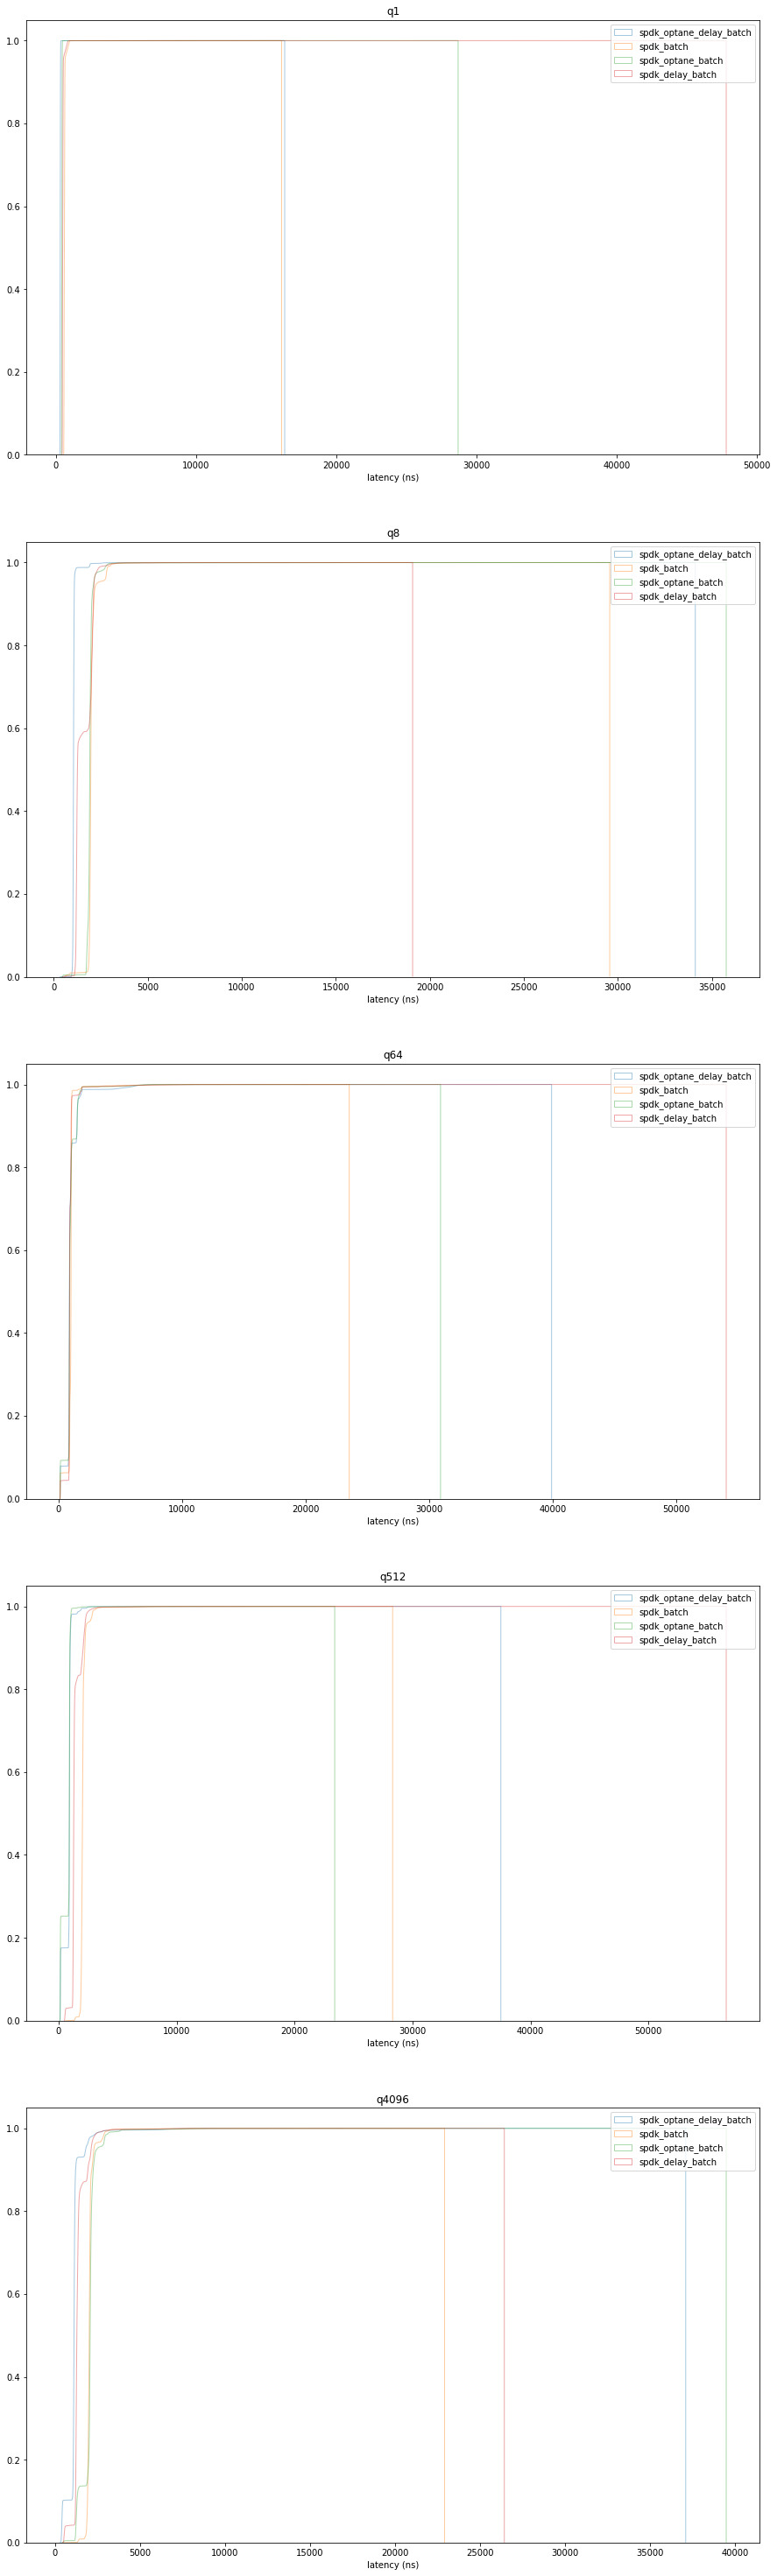

In [64]:
figSubmitLat, axesSubmitLat = plt.subplots(nrows=len(queue_sizes), ncols=1,
                                           figsize=(large_fig_dim[0], large_fig_dim[1] * len(queue_sizes)))
for obj in subObjs:
    sns.distplot(obj['df']['latency (ns)'], kde=False, hist=True, rug=False, bins=obj['df'].size,
                 hist_kws={'histtype': 'step', 'density': True, 'cumulative': True},
                 label=obj['device'],
                 ax=axesSubmitLat[queue_sizes.index(obj['queueSize'])])
    
for i in range(len(queue_sizes)):
    axesSubmitLat[i].set_title('q' + str(queue_sizes[i]))
    axesSubmitLat[i].legend()

In [122]:
for obj in subObjs:
    obj['SubmitDiff'] = obj['df']['start time (ns)'].diff()

In [123]:
submitDifs = {}
for op in op_types:
    submitDifs[op] = pd.DataFrame()
    for obj in subObjs:
        if obj['op'] != op:
            continue
        submitDifs[op] = submitDifs[op].append({
            'Device': obj['device'],
            'average submit dif (us)': obj['SubmitDiff'].mean() / 1000,
            'max queue depth': obj['queueSize'],
            'block size': int(obj['blockSize']),
        }, ignore_index=True)

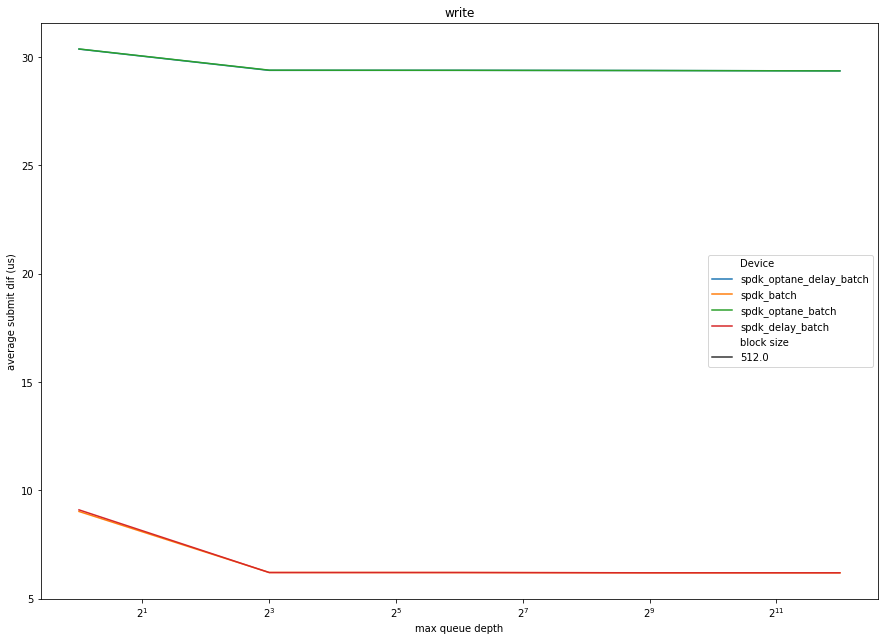

In [124]:
figSubmitDifs, axesSubmitDifs = plt.subplots(nrows=len(submitDifs), ncols=1,
                                     figsize=(large_fig_dim[0], large_fig_dim[1] * len(submitDifs)))
row = 0
for k, p in submitDifs.iteritems():
    sns.lineplot(x='max queue depth', y='average submit dif (us)', data=p,
                 hue='Device', style='block size', ax=axesSubmitDifs)
    axesSubmitDifs.set_xscale('log', basex=2)
    axesSubmitDifs.set_title(k)
    row += 1

In [125]:
pciObjs = []

In [126]:
pcif = '_pcie-mon.log'

for op in op_types:
    for qs in queue_sizes:
        for dev in devs:
            for bs in blk_sizes:
                if 'spdk4096' in dev and bs != 4096:
                    # Minimum block size for this device is 4K.
                    continue
                pciObjs.append({
                    'op': op,
                    'queueSize': qs,
                    'blockSize': bs,
                    'device': dev,
                    'filePath': os.path.join(
                                    os.path.join(
                                        os.path.join(
                                            os.path.join(
                                                os.path.join(base_path, op),
                                                'q' + str(qs)),
                                            dev),
                                        'bs' + str(bs)),
                                    pcif)
                })

In [127]:
for obj in pciObjs:
    obj['df'] = pd.read_csv(obj['filePath'], sep=',',
                            names=['start time (ns)', 'latency (ns)', 'num events', 'event'])

In [128]:
for obj in pciObjs:
    obj['df']['start time (ms)'] = obj['df']['start time (ns)'] / 1000 / 1000

In [182]:
bins = [100 * x for x in range(0, 122)]
for obj in subObjs:
    if obj['device'] != 'spdk_batch' or obj['queueSize'] != 8:
        continue
    #print (obj['df']['start time (ns)'] / 1000 / 1000).max()
    startCounts = pd.cut(obj['df']['start time (ns)'] / 1000 / 1000, bins, labels=bins[:len(bins) - 1]).value_counts()
    #obj['df'].append(pd.cut(obj['df']['start time (ns)'] / 1000 / 1000, bins, labels=bins[:len(bins) - 1]))
    obj['df']['start time (ms)'] = (obj['df']['start time (ns)'] / 1000 / 1000 / 100).astype(int)
    obj['df']['dummy'] = 1
    obj['df']['start time (ms)'] = obj['df']['start time (ms)'] * 100

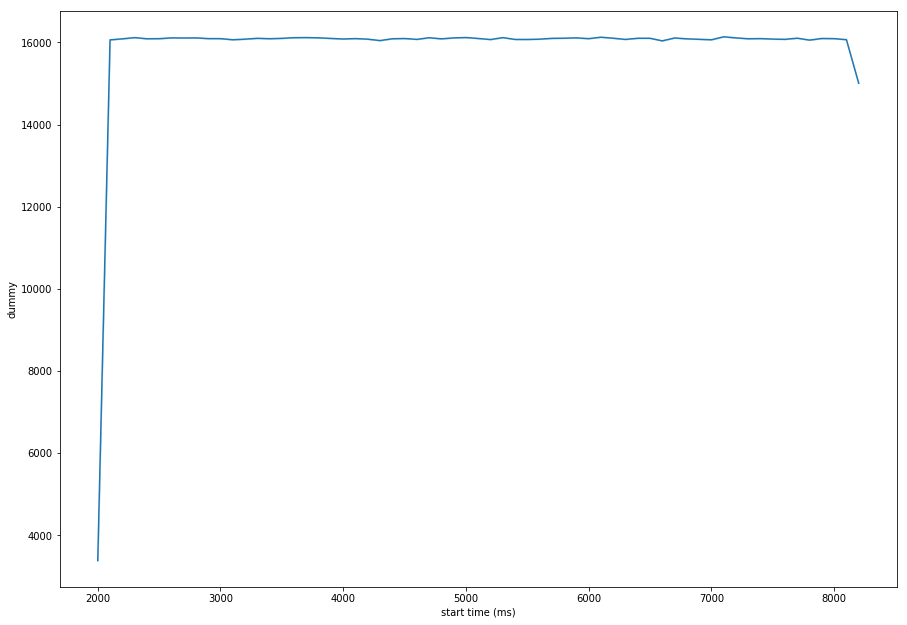

In [183]:
figSubmits, axesSubmits = plt.subplots(figsize=(large_fig_dim))
for obj in subObjs:
    if obj['device'] != 'spdk_batch' or obj['queueSize'] != 8:
        continue
    sns.lineplot(x='start time (ms)', y='dummy', data=obj['df'], ax=axesSubmits, estimator=sum)

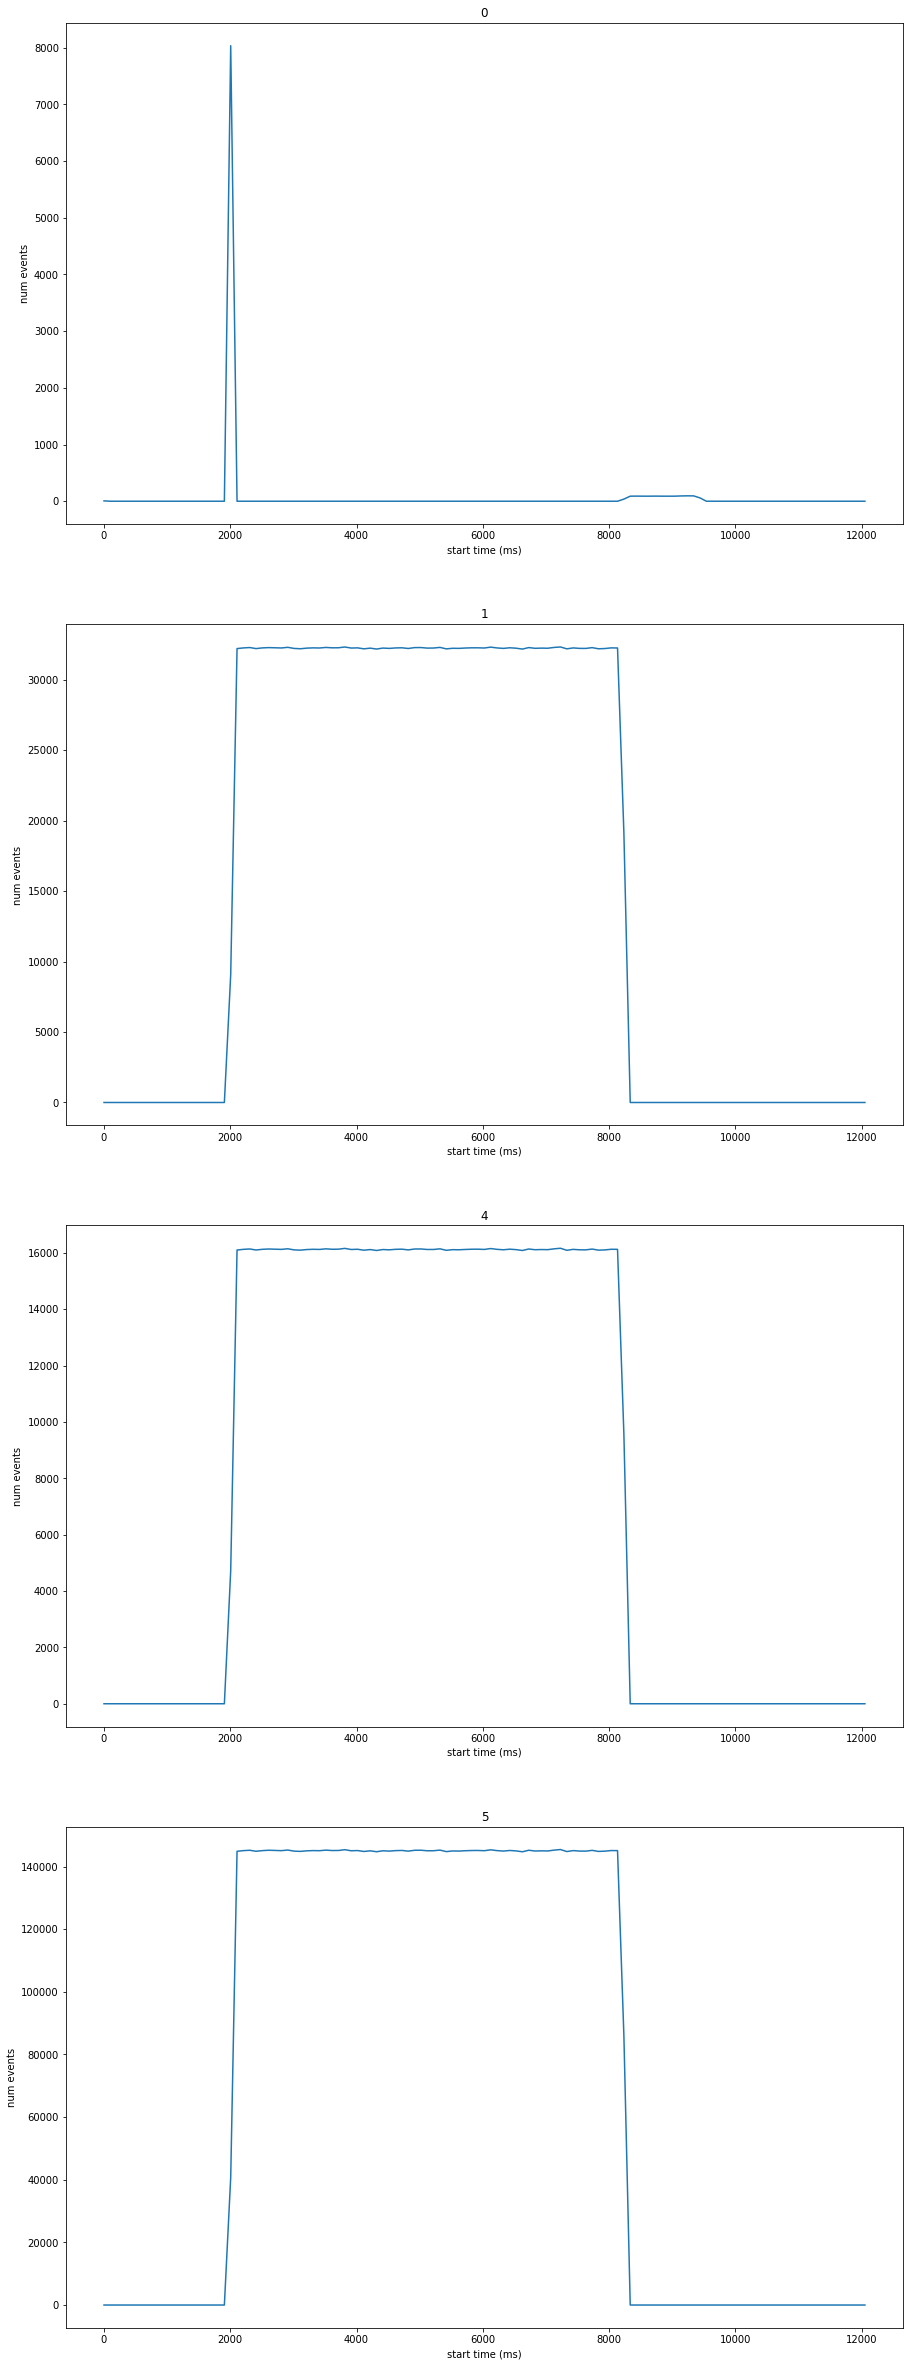

In [186]:
figPci, axesPci = plt.subplots(nrows=4, ncols=1, figsize=(large_fig_dim[0], large_fig_dim[1] * 4))
events = [0, 1, 4, 5]
i = 0
for i in range(0, 4):
    for obj in pciObjs:
        if obj['device'] != 'spdk_batch' or obj['queueSize'] != 8:
            continue
        sns.lineplot(x='start time (ms)', y='num events', data=obj['df'][obj['df']['event'] == events[i]], ax=axesPci[i])
        axesPci[i].set_title(events[i])

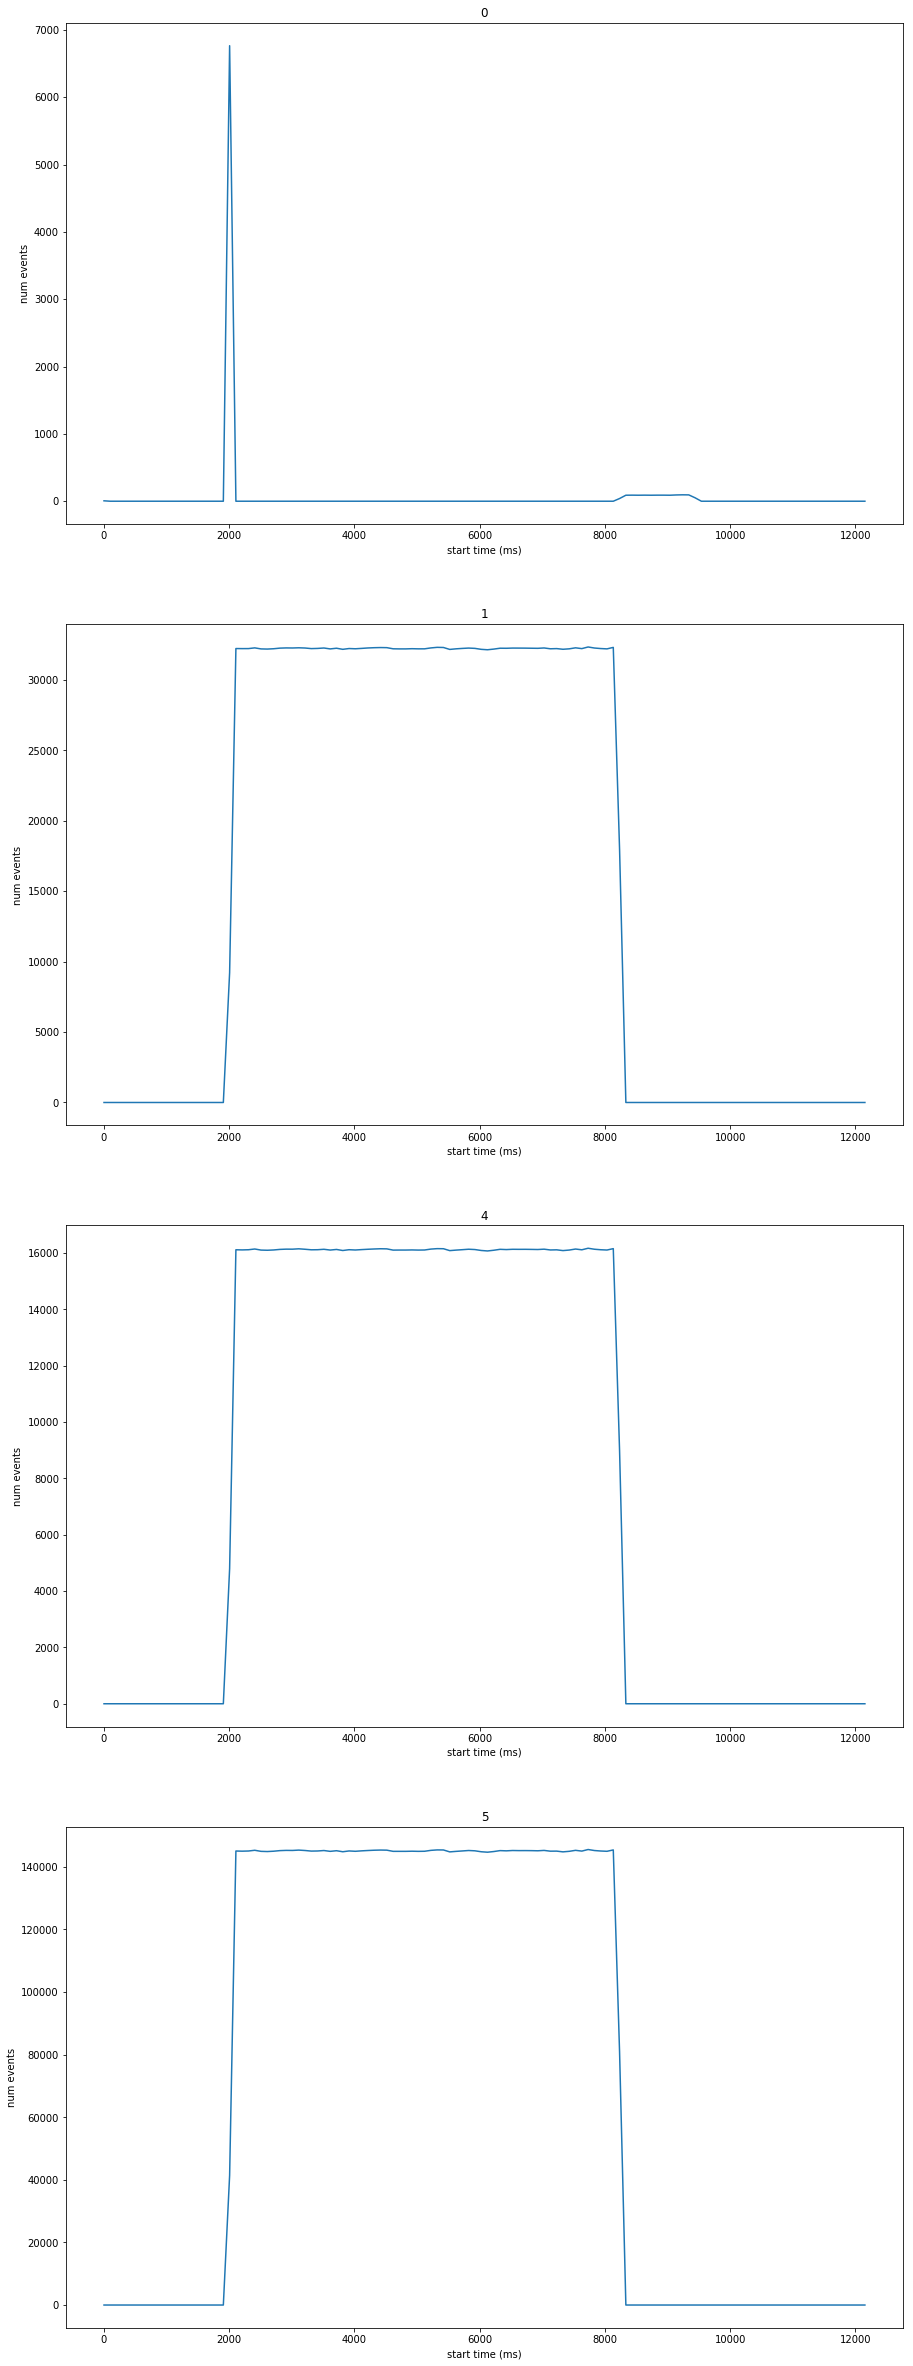

In [187]:
figPci, axesPci = plt.subplots(nrows=4, ncols=1, figsize=(large_fig_dim[0], large_fig_dim[1] * 4))
events = [0, 1, 4, 5]
i = 0
for i in range(0, 4):
    for obj in pciObjs:
        if obj['device'] != 'spdk_delay_batch' or obj['queueSize'] != 8:
            continue
        sns.lineplot(x='start time (ms)', y='num events', data=obj['df'][obj['df']['event'] == events[i]], ax=axesPci[i])
        axesPci[i].set_title(events[i])